In [53]:
%matplotlib inline
import time
import numpy as np
np.set_printoptions(formatter={'float': lambda x: format(x, '.4e')})
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d
from datetime import datetime

## Objective function

Consider the Rosenbrock function

In [54]:
def rose_fun(x):
    x = np.asarray(x)
    r = 0.
    for i in range(len(x)-1):
        r += 100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2
    return r

def rose_dfun(x):
    x = np.asarray(x)
    df = np.zeros_like(x)
    for i in range(len(x)-1):
        df[i] += -400*(x[i+1]*x[i]-x[i]**3) - 2*(1-x[i])
        df[i+1] += 200*(x[i+1]-x[i]**2)
    return df

def rose(x):
    return rose_fun(x), rose_dfun(x)

## Visualize the objective function

Text(0.5, 0.92, 'rose_fun')

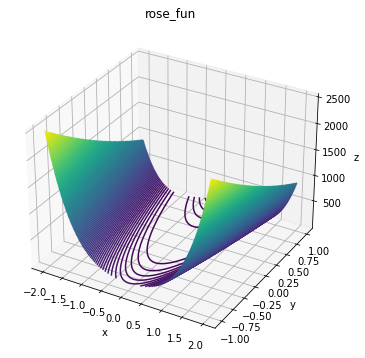

In [55]:
# this f is the name of savefig as well
f = rose_fun

# the boundary for testing
b_x = np.linspace(-2, 2, 100) 
b_y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(b_x, b_y)
# Or, change np.array as torch.tensor
Z = f(np.array([X, Y]))

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 150, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('{}'.format(f.__name__))

## AAGD_m, AA-AEGD_m

In [56]:
def aagd_m(func, xs, Gs, p, k):
    # func: [f(x), df(x)]
    # xs = [x(0), x(1), ..., x(k)]
    # Gs = [x(k-m)-eta*df(k-m), ..., x(k-1)-eta*df(k-1)] 
    # k: the current step
    # default seting: p[online = True, eta=1e-4, m=2, beta=1, gap=100, maxiter=2000, tol=1e-5]
    
    eta = p['eta']
    beta = p['beta']
    m = p['m'] # the length of the window

    if not p['online']: # the switch of on/ offline
      m = min(p['m'], k)
    Xs, x = xs[-m-1:-1], xs[-1]
    # Xs = [x(k-m), ..., x(k-1)] # x0
    # x = x(k) x1
    
    Xs = np.asarray(Xs, dtype=np.float32)
    Gs = np.asarray(Gs, dtype=np.float32)
    
    Gk = x - eta * func(x)[1] # G1
    _x = Gk # x2
    

    freq = m if p['online'] else 1
    if k % freq == 0:
      Fs = Gs - Xs # Fs = [-eta*df(k-m), ..., -eta*df(k-1)] 
      Fk = Gk - x # F1
      # using QR decomposition to solve the least-square problem
      # [df(k)-df(k-m), ..., df(k)-df(k-1)] * theta = df(k)
      # refer Wikipedia/Anderson acceleration
      theta = np.linalg.lstsq((Fk - Fs).T, Fk, rcond=None)[0]
      x_ext = (1-beta) * (x + theta @ (Xs-x)) + beta * (Gk + theta @ (Gs-Gk))
      _x = x_ext
    
    return _x, Gk

In [57]:
def aaegd_m(func, xs, Gs, r, p, k):
    # func: [f(x), df(x)]
    # xs = [x(0), x(1), ..., x(k)]
    # Gs = [x(k-m)-eta*df(k-m), ..., x(k-1)-eta*df(k-1)] 
    # k: the current step
    # default seting: p[online = True, eta=1e-4, m=2, beta=1, gap=100, maxiter=2000, tol=1e-5]
    
    eta = p['eta']
    beta = p['beta']
    m = p['m'] # the length of the window

    if not p['online']: # the switch of on/ offline
      m = min(p['m'], k)
    Xs, x = xs[-m-1:-1], xs[-1]
    # Xs = [x(k-m), ..., x(k-1)] # x0
    # x = x(k) x1
    
    Xs = np.asarray(Xs, dtype=np.float32)
    Gs = np.asarray(Gs, dtype=np.float32)
    
    # AEGD, c=1
    v = func(x)[1] / (2*np.sqrt(func(x)[0] + 1))
    _r = r / (1 + 2*eta * v**2)
    Gk = x - 2*eta * _r * v  # G1
    _x = Gk # x2
    

    freq = m if p['online'] else 1
    if k % freq == 0:
      Fs = Gs - Xs # Fs = [-eta*df(k-m), ..., -eta*df(k-1)] 
      Fk = Gk - x # F1
      # using QR decomposition to solve the least-square problem
      # [df(k)-df(k-m), ..., df(k)-df(k-1)] * theta = df(k)
      # refer Wikipedia/Anderson acceleration
      theta = np.linalg.lstsq((Fk - Fs).T, Fk, rcond=None)[0]
      x_ext = (1-beta) * (x + theta @ (Xs-x)) + beta * (Gk + theta @ (Gs-Gk))
      _x = x_ext
    
    return _x, Gk, _r

## runners

In [58]:
def runner(x0, func, optim, p):
    t = time.time()
    
    # initialization
    if optim != aegd:
        r0 = np.zeros_like(x0)
    else: #AEGD
        r0 = np.sqrt(func(x0)[0]+1) * np.ones_like(x0)

    res = dict(fs=[func(x0)[0]], xs=[x0+1e-2], rs=[r0], vs=[0], Gs=[], Fts=[])
    fs, xs, rs, vs, Gs, Fts= res['fs'], res['xs'], res['rs'], res['vs'], res['Gs'], res['Fts']
    
    k = 1
    xs.append(x0)
    
    
    while np.linalg.norm(xs[-1]-xs[-2]) > p['tol']*(1+np.linalg.norm(xs[-2])) and k < p['maxiter']:
        f, x, v, r, grad = optim(k, xs[-1], vs[-1], rs[-1], func, p)
        fs.append(f)
        xs.append(x)
        rs.append(r)
        vs.append(v)

        if k % p['gap'] == 0:
            print('[{:4}], f: {:.4e}, grad: {}'.format(k, f, grad[:2]))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k-1))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1][:2]))
        
    return res, p, elapsed

In [59]:
def runner_on(func, x0, optim, p):
    t = time.time()
    
    f, df = func(x0)

    # initialization
    if optim != aaegd_m:
        # AA-GD_m
        res = dict(fs=[f], Gs=[x0 - p['eta'] * (df)], xs=[x0, x0 - p['eta'] * (df)]) 
        fs, Gs, xs = res['fs'], res['Gs'], res['xs']
    else: # AA-AEGD_m
        r0 = np.sqrt(f+1) * np.ones_like(x0)
        # v1 = df / (2*np.sqrt(f+1))
        # r1 = r0 / (1 + 2*p['eta'] * v1**2)
        # x1 = x0 - 2*p['eta'] * r1 * v1

        res = dict(fs=[f], Gs=[x0], xs=[x0+1e-2, x0], rs=[r0]) 
        fs, Gs, xs, rs = res['fs'], res['Gs'], res['xs'], res['rs']
    
    k = 1
    while np.linalg.norm(xs[-1]-xs[-2]) > p['tol']*(1+np.linalg.norm(xs[-2])) and k < p['maxiter']:
    #while abs(fs[-1]-1) > p['tol'] and k < p['maxiter']: 

        if optim != aaegd_m:
            # AAGD_m
            # compute x(k+1)
            x, Gk = optim(func, xs, Gs, p, k) 
            # Update xs, Gs
            if k >= p['m']:
                #xs = xs[1:]
                Gs = Gs[1:]

        else: # AA-AEGD_m
            # compute x(k+1)
            x, Gk, r = optim(func, xs, Gs, rs[-1], p, k) 
            # Update xs, Gs
            if k >= p['m']:
                #xs = xs[1:]
                Gs = Gs[1:]
            rs[-1] = r #

        xs.append(x) # 
        Gs.append(Gk) # 
        f, df = func(x)
        fs.append(f)

        if k % p['gap'] == 0:
            print('[{:}], f: {:.4e}, |df|:{:.4e}'.format(k, f, np.linalg.norm(df)))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1][:2]))
        
    return res


## 2-D

In [60]:
x0_2 = np.array([1.5,-0.5]) #np.ones(2)
f_r2 = rose

In [61]:
aagd_m_2 = runner_on(func=f_r2, x0=x0_2, optim=aagd_m, 
            p=dict(online = True, eta=1.9e-4, m=3, beta=1, gap=100, maxiter=10000, tol=1e-6))
# iterations: 74
# solution time: 0.0069s
# current function value: 3.109552020393467e-08
# current parameter value: [9.9985e-01 9.9970e-01]

aagd_m_2_off = runner_on(func=f_r2, x0=x0_2, optim=aagd_m, 
            p=dict(online = False, eta=0.99e-4, m=3, beta=1, gap=100, maxiter=10000, tol=1e-6))

------------------
iterations: 74
solution time: 0.0035s
current function value: 3.109552020393467e-08
current parameter value: [9.9985e-01 9.9970e-01]
[100], f: 1.0496e-02, |df|:4.6060e+00
------------------
iterations: 116
solution time: 0.0062s
current function value: 3.403833103497423e-11
current parameter value: [9.9999e-01 9.9999e-01]


In [62]:
aaegd_m_2 = runner_on(func=f_r2, x0=x0_2, optim=aaegd_m, 
                    p=dict(online = True, eta=6.4e-3, m=3, beta=1, gap=100, maxiter=10000, tol=1e-6))
# iterations: 20
# solution time: 0.0024s
# current function value: 1.233041806143901e-09
# current parameter value: [1.0000e+00 1.0001e+00]

aaegd_m_2_off = runner_on(func=f_r2, x0=x0_2, optim=aaegd_m, 
                    p=dict(online = False, eta=9.8e-6, m=3, beta=1, gap=100, maxiter=10000, tol=1e-6))

------------------
iterations: 20
solution time: 0.0016s
current function value: 1.233041806143901e-09
current parameter value: [1.0000e+00 1.0001e+00]
------------------
iterations: 96
solution time: 0.0061s
current function value: 6.765734236492101e-13
current parameter value: [1.0000e+00 1.0000e+00]


### Experiment: 2D non-convex AEGD, AGEM and AA-AEGD

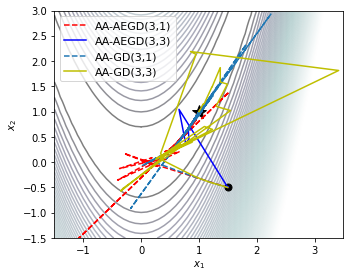

In [63]:
xa, ya = [z[0] for z in aagd_m_2['xs']], [z[1] for z in aagd_m_2['xs']]
xae, yae = [z[0] for z in aaegd_m_2['xs']], [z[1] for z in aaegd_m_2['xs']]
xaf, yaf = [z[0] for z in aagd_m_2_off['xs']], [z[1] for z in aagd_m_2_off['xs']]
xef, yef = [z[0] for z in aaegd_m_2_off['xs']], [z[1] for z in aaegd_m_2_off['xs']]


# adjust the print boundry
xmin, xmax, xstep = -1.5, 3.5, .1
ymin, ymax, ystep = -1.5, 3., .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep),
                   np.arange(ymin, ymax + ystep, ystep))
z = f([x, y])

# adjust the minima manually
minima = np.array([1, 1])
minima_ = minima.reshape(-1, 1)

initial_ = x0_2.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(x, y, z, levels=np.arange(0, 5000, 50), norm=LogNorm(),
                alpha=0.5, cmap=plt.cm.bone)
#ax.clabel(CS, fontsize=10, inline=False)
ax.plot(*minima_, 'k*', markersize=14)
ax.plot(*initial_, 'ko', markersize=7)

ax.plot(xef[0:], yef[0:], color='r', ls='--', label='AA-AEGD(3,1)')
ax.plot(xae[0:], yae[0:], color='b', label='AA-AEGD(3,3)')
ax.plot(xaf[0:], yaf[0:], color='#1f77b4', ls='--', label='AA-GD(3,1)')
ax.plot(xa[0:], ya[0:], color='y', label='AA-GD(3,3)')

# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.rcParams.update({'font.size': 11})
plt.legend(loc=2, prop={'size': 11})
plt.tight_layout()
plt.savefig('plot/2Drosen_path.png', dpi=300)
#plt.title('{}'.format(f.__name__))